# Task -1 Anomaly detection
## Student ID1: 207276775

In [2]:
# Imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
# data wrangling
from sklearn.cluster import DBSCAN

## Read the data
In this section we will read the information we received from the file for which we will need to perform anomaly detection

In [4]:
f_path = "/Users/97252/Downloads/conn_attack.csv"
'''
record ID - The unique identifier for each connection record.
duration_  This feature denotes the number of seconds (rounded) of the connection. For example, a connection for 0.17s or 0.3s would be indicated with a “0” in this field.
src_bytes This field represents the number of data bytes transferred from the source to the destination (i.e., the amount of out-going bytes from the host).
dst_bytes This fea
ture represents the number of data bytes transferred from the destination to the source (i.e., the amount of bytes received by the host).
'''
df = pd.read_csv(f_path,names=["record ID","duration_", "src_bytes","dst_bytes"], header=None)
df

,record ID,duration_,src_bytes,dst_bytes
0,1,0,236,1228
1,2,0,239,486
2,3,0,234,1364
3,4,0,239,1295
4,5,0,181,5450
...,...,...,...,...
256665,256666,0,306,236
256666,256667,0,288,4017
256667,256668,0,289,1096
256668,256669,0,198,2169


# # Pandas DataFrame


A. Handling missing data

In [8]:
# determin the missing data precentage
df.apply(lambda x: sum(x.isna()) / len(df))

record ID    0.0
duration_    0.0
src_bytes    0.0
dst_bytes    0.0
dtype: float64

B. Remove na/nan: ##The Pandas function dropna() drops rows or columns (depending on the parameter you choose) that contain missing values. This function takes the axis parameter which you set as 0 to drop rows, and 1 to drop columns.

In [10]:
df.shape


(256670, 4)

In [11]:
df.isnull().any().any() # check if we have nan values.

False

E. Describe

In [12]:
#Mean
df['dst_bytes'].mean()

4473.532613862158

In [13]:
#Median of two seperate columns
df[["src_bytes", "dst_bytes"]].median()

src_bytes     249.0
dst_bytes    1661.0
dtype: float64

In [14]:
#Instead of the predefined statistics, specific combinations can be calculated
df.agg(
    {
        "duration_": ["min", "max", "median", "skew"],
        "dst_bytes": ["min", "max", "median", "mean"],
    }
)

,duration_,dst_bytes
min,0.000000,0.000000e+00
max,3289.000000,7.068759e+06
median,0.000000,1.661000e+03
skew,74.033196,NaN
mean,NaN,4.473533e+03


## Data exploration

### Explore the data, understand the featues, statistics visualize the inputs

skew:
    
    In probability theory and statistics, skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. The skewness value can be positive, zero, negative, or undefined.


In [16]:
'''
Deviate from the normal distribution.
Have appreciable positive skewness.
Show peakedness.
'''
#skewness and kurtosis
print("Skewness: %f" % df['src_bytes'].skew())
print("Kurtosis: %f" % df['src_bytes'].kurt()) # positive show long tail , negative light tail

Skewness: 15.824471
Kurtosis: 248.739606


C:\Users\97252\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: 207.100418
Kurtosis: 61028.785029


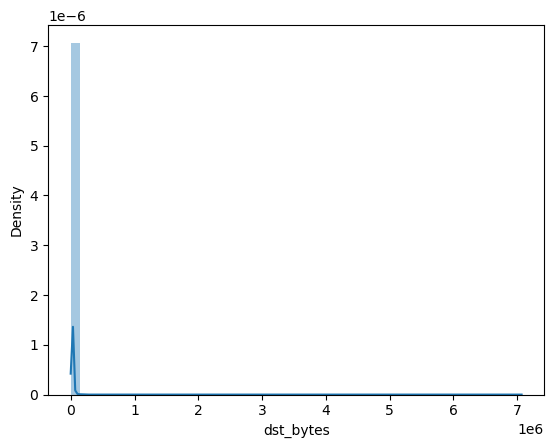

In [20]:
sns.distplot(df['dst_bytes'])
print("Skewness: %f" % df['dst_bytes'].skew())
print("Kurtosis: %f" % df['dst_bytes'].kurt())

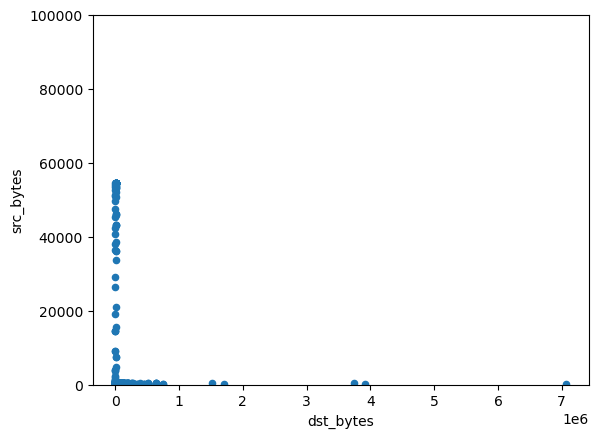

In [5]:
#Relationship with numerical variables
var = 'dst_bytes'
data = pd.concat([df['src_bytes'], df[var]], axis=1)
data.plot.scatter(x=var, y='src_bytes', ylim=(0,100000)); # do not `assume here any thing this is just examples

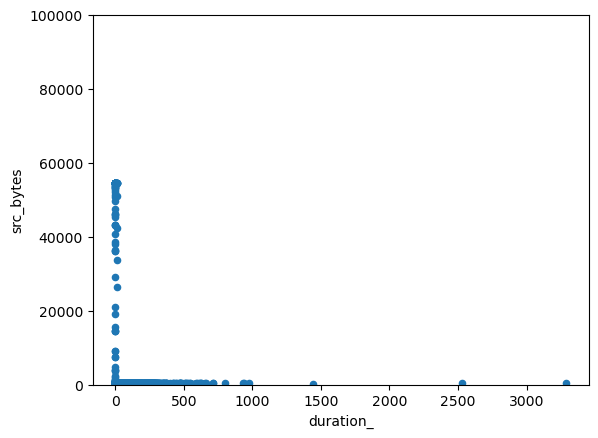

In [22]:
#scatter plot totalbsmtsf/saleprice
var = 'duration_'
data = pd.concat([df['src_bytes'], df[var]], axis=1)
data.plot.scatter(x=var, y='src_bytes', ylim=(0,100000));

In [23]:
df.corr() 

,record ID,duration_,src_bytes,dst_bytes
record ID,1.000000,0.027244,0.019209,-0.002970
duration_,0.027244,1.000000,-0.001714,-0.005791
src_bytes,0.019209,-0.001714,1.000000,0.010770
dst_bytes,-0.002970,-0.005791,0.010770,1.000000


## Memory Heat Map (MHM)
According to the article:
http://www.cs.yale.edu/homes/yoon-man-ki/DAC2015_MemoryHeatMap.pdf ,
The efficiency can be seen in the Memory Heat Map (MHM) to characterize the memory behavior of the operating system and to identify an anomaly in a real-time system.

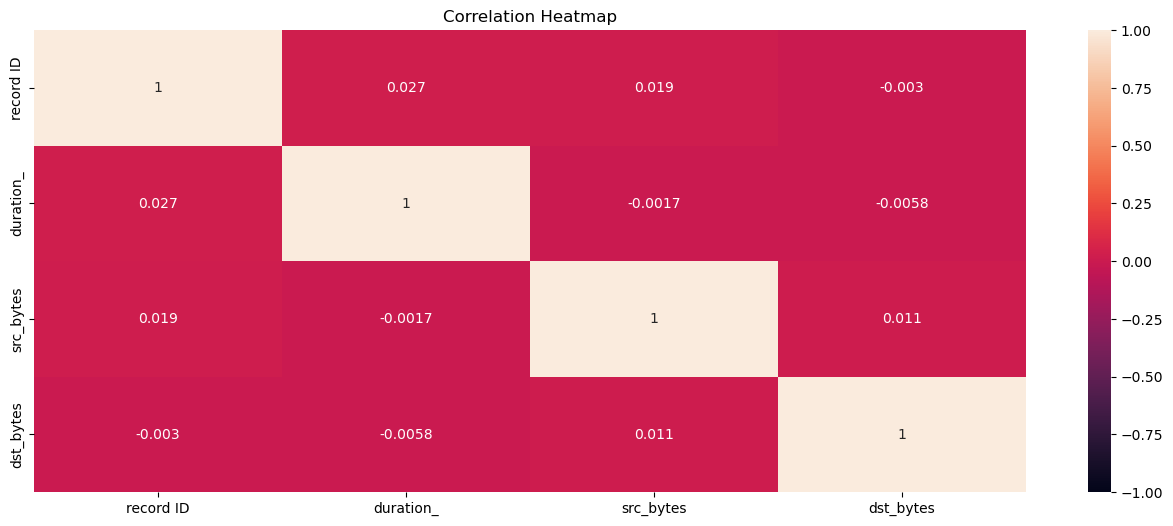

In [24]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12});

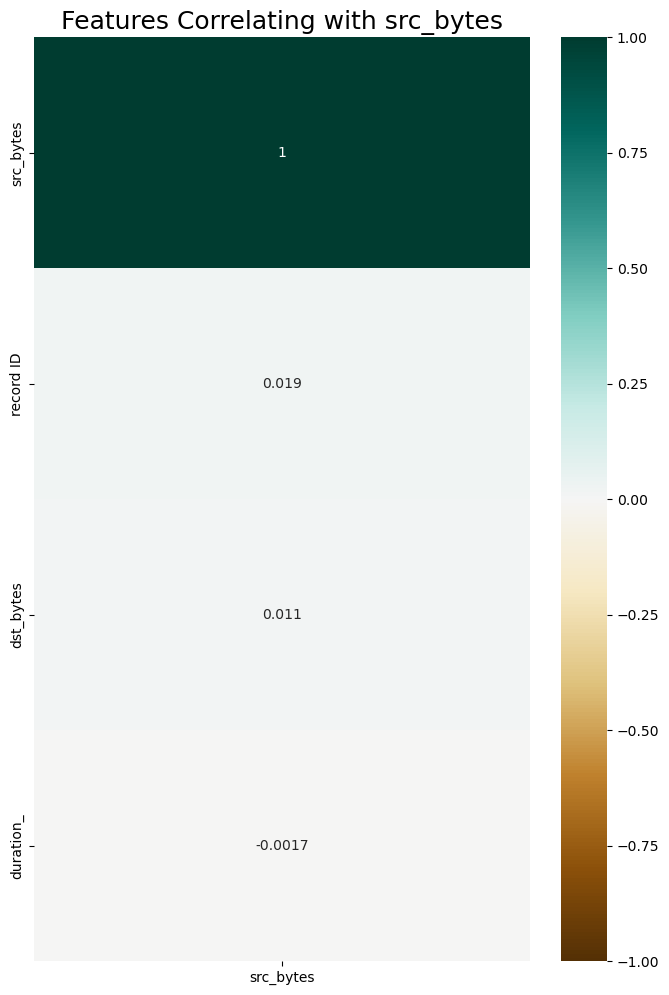

In [25]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['src_bytes']].sort_values(by='src_bytes', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with src_bytes', fontdict={'fontsize':18});

# Data exploration
## What is Data Exploration?
Data exploration definition: Data exploration refers to the initial step in data analysis in which data analysts use data visualization and statistical techniques to describe dataset characterizations, such as size, quantity, and accuracy, in order to better understand the nature of the data.

https://www.heavy.ai/learn/data-exploration 

# Anomaly detection using Isolation Forest

(Definition from the presentation of lecture 3): 
### Isolation Forest
• Choosing a record within the dataset and its variables;

• Choosing a random value within the minimum and maximum of each variable or from uniform distribution;

• Creating a node or branch: if the value of the record under consideration is greater or less than the previous random value, we repeat the exercise of evaluating our point with the minimum and maximum interval, limiting it further this time, with the cut-off point being the new maximum or minimum of the branch created.

• Executing the third step until further branching is not possible and the point to be evaluated is isolated.

• Thus, the fewer branches needed by the tree to isolate the point, the more
anomalous it will be

### Theory
The main idea, which is different from other popular outlier detection methods, is that Isolation Forest explicitly identifies anomalies instead of profiling normal data points. Isolation Forest, like any tree ensemble method, is built on the basis of decision trees. In these trees, partitions are created by first randomly selecting a feature and then selecting a random split value between the minimum and maximum value of the selected feature.

In principle, outliers are less frequent than regular observations and are different from them in terms of values (they lie further away from the regular observations in the feature space). That is why by using such random partitioning they should be identified closer to the root of the tree (shorter average path length, i.e., the number of edges an observation must pass in the tree going from the root to the terminal node), with fewer splits necessary.
As with other outlier detection methods, an anomaly score is required for decision making. In the case of Isolation Forest, it is defined as:

## $$s(x,n)=2^\frac{-E(h(x))}{c(n)} $$

*h(x) is the path length of observation x

*c(n) is the average path length of unsuccessful search in a Binary Search Tree

*n is the number of external nodes

https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e

### Isolation Forest Algorithm.

Return the anomaly score of each sample using the IsolationForest algorithm

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

### code 

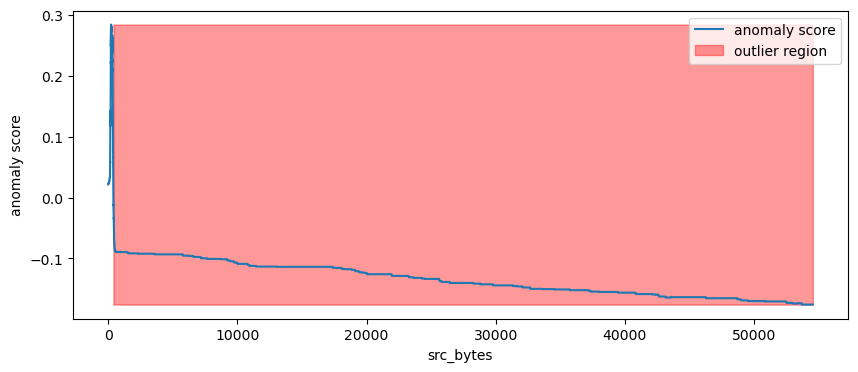

In [157]:
from sklearn.ensemble import IsolationForest
#n_estimatorsint, default=100: The number of base estimators in the ensemble.
isolation_forest = IsolationForest(contamination=0.01, n_estimators=100)
#fit(X, y=None, sample_weight=None)[source]: Fit estimator
#reshape: The function flattens a nested array of an unknown number of elements into a 1D array
isolation_forest.fit(df['src_bytes'].values.reshape(-1, 1))
#The NumPy linspace function (sometimes called np. linspace) is a tool in Python for creating numeric sequences.
xx = np.linspace(df['src_bytes'].min(), df['src_bytes'].max(), len(df)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
#predict() : given a trained model, predict the label of a new set of data. This method accepts one argument, the new data X_new (e.g. model. predict(X_new) ), and returns the learned label for each object in the array
outlier = isolation_forest.predict(xx)
#figsize is a tuple of the width and height of the figure in inches
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('src_bytes')
plt.show();

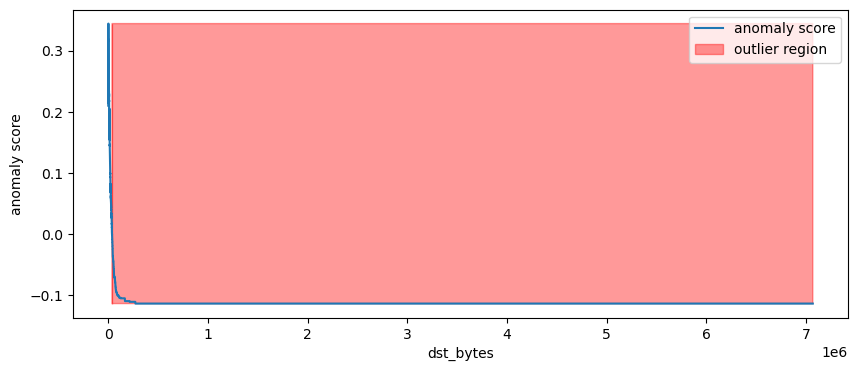

In [182]:
from sklearn.ensemble import IsolationForest
#n_estimatorsint, default=100: The number of base estimators in the ensemble.
isolation_forest = IsolationForest(contamination=0.01, n_estimators=100)
#fit(X, y=None, sample_weight=None)[source]: Fit estimator
#reshape: The function flattens a nested array of an unknown number of elements into a 1D array
isolation_forest.fit(df['dst_bytes'].values.reshape(-1, 1))
#The NumPy linspace function (sometimes called np. linspace) is a tool in Python for creating numeric sequences.
xx = np.linspace(df['dst_bytes'].min(), df['dst_bytes'].max(), len(df)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
#predict() : given a trained model, predict the label of a new set of data. This method accepts one argument, the new data X_new (e.g. model. predict(X_new) ), and returns the learned label for each object in the array
outlier = isolation_forest.predict(xx)
#figsize is a tuple of the width and height of the figure in inches
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('dst_bytes')
plt.show();

In [179]:
#We learned in lecture 2 that for the generated data set, the first n-1 columns
#constitute the input attributes and thelast one constitutes the target attributes(label)
input_attributes=df[["duration_", "src_bytes","dst_bytes"]]

In [180]:
isolation_forest.fit(input_attributes.values)

IsolationForest(contamination=0.01)

In [181]:
df["anomaly"] = pd.Series(isolation_forest.predict(input_attributes.values))
df["anomaly"] = df["anomaly"].map({1:0, -1:1})
print(df["anomaly"].value_counts())

0    254104
1      2566
Name: anomaly, dtype: int64


In [107]:
f_path ="/Users/97252/Downloads/conn_attack_anomaly_labels.csv"
df_example = pd.read_csv(f_path,names=["record ID","anomaly"], header=None)
print(df_example["anomaly"].value_counts())

0    255648
1      1022
Name: anomaly, dtype: int64


Definition of the Terms:

True Positive (TP) : Observation is positive, and is predicted to be positive.

False Negative (FN) : Observation is positive, but is predicted negative.

True Negative (TN) : Observation is negative, and is predicted to be negative.

False Positive (FP) : Observation is negative, but is predicted positive.

In [183]:
# TP=df_example.where(df_example["anomaly"] == 1)["anomaly"].value_counts()
# TN=df_example.where(df_example["anomaly"] == 0)["anomaly"].value_counts()
# FP=df.where(df["iforest"] == 1)["iforest"].value_counts()
# FN=df.where(df["iforest"] == 0)["iforest"].value_counts()
# print((TP+TN)/(TP+TN+FP+FN))

In [184]:
# model_fit = IsolationForest(contamination=0.12,n_estimators = 100).fit(TP, TN)
# y_pred = model_fit.predict(x_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("accuracy score: {0:.2f}%".format(accuracy*100))

## References
Understanding the material:

https://www.youtube.com/watch?v=cRzeotaFDwk&ab_channel=MachineLearningInterview
https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e
https://www.heavy.ai/learn/data-exploration
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html -contributed in understanding the functions of the algorithm